## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats
sns.set()

import warnings
warnings.filterwarnings('ignore')

## Loading and Transforming Data

In [2]:
# Importing the Data
file_name = Path('./Data/Index2018.csv')
df = pd.read_csv(file_name, parse_dates=True, index_col='date', infer_datetime_format=True, dayfirst=True) 
df.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25
1994-01-12  474.17  2182.06  3372.02  18793.88
1994-01-13  472.47  2142.37  3360.01  18577.26

In [3]:
df = df.asfreq('b')
df.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25
1994-01-12  474.17  2182.06  3372.02  18793.88
1994-01-13  472.47  2142.37  3360.01  18577.26

In [4]:
df = df.fillna(method='ffill')
df.head()

spx      dax     ftse    nikkei
date                                          
1994-01-07  469.90  2224.95  3445.98  18124.01
1994-01-10  475.27  2225.00  3440.58  18443.44
1994-01-11  474.13  2228.10  3413.77  18485.25
1994-01-12  474.17  2182.06  3372.02  18793.88
1994-01-13  472.47  2142.37  3360.01  18577.26

## S&P500 Data Only

In [5]:
# SPX data
spx_data = df['spx'].to_frame()

# Train and Test Split
train_size = int(len(spx_data)*0.8)
train_spx = spx_data.iloc[:train_size]
test_spx = spx_data.iloc[train_size:]

## White Noise

In [6]:
wn_data = np.random.normal(loc=train_spx.mean(), scale=train_spx.std(), size=len(train_spx))
train_spx['wn'] = wn_data

## Random Walk

In [7]:
rw_data = pd.read_csv(Path('./Data/RandWalk.csv'), parse_dates=True, infer_datetime_format=True, index_col='date', dayfirst=True)
rw_data = rw_data.asfreq('b')
train_spx['rw'] = rw_data

# Seasonality

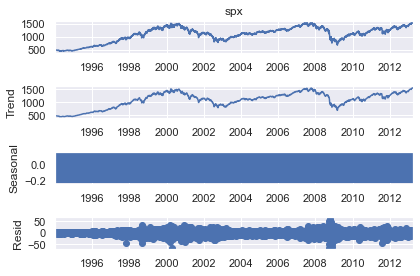

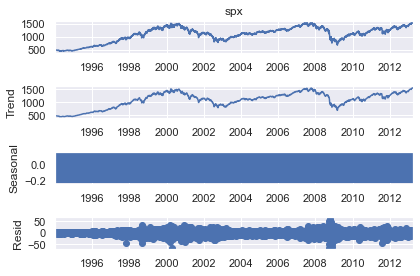

In [8]:
# Additive method
seasonal_dec_additive = seasonal_decompose(train_spx['spx'], model="additive")
seasonal_dec_additive.plot()
plt.show()

Observations

1. Trend plot more similar to actual time series since it uses previous period values as a trend-setter. This part explain variablility of the data
2. Seasonal plot values are constantly ocillating back and forth between -0.2 and 0.0. So there is NO CYCLICAL PATTERN can be found using this model
3. Residual plot can see around 2000 and 2008 have more residulas because of dot.com crash and real estate crash respectively

So, using Additive model, we could not find any Seasonality in the spx data

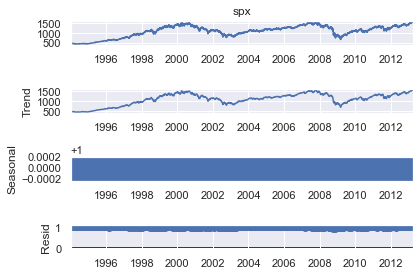

In [9]:
# Multiplicative method
seasonal_dec_multiplicative = seasonal_decompose(train_spx['spx'], model="multiplicative")
seasonal_dec_multiplicative.plot()
plt.show()

Observations

Same like Additive model, NO SEASONAL PATTERN in SPX data

Summary

Since trend follows a close pattern to Actual data, we can further exploer its correlation between past and present values

# Autocorrelation

Autocorrelation function (ACF) will be used to compute correlation values between different Lags

Correlation values are between -1 to +1

### ACF

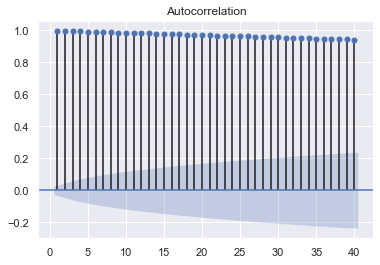

In [10]:
sgt.plot_acf(train_spx['spx'], lags=40, zero=False)
# lags=40 meaning past 40 days from current day
# zero=False meaning current day not includs, because no point doing correlation of current day to iteself since it is always 1
plt.show()

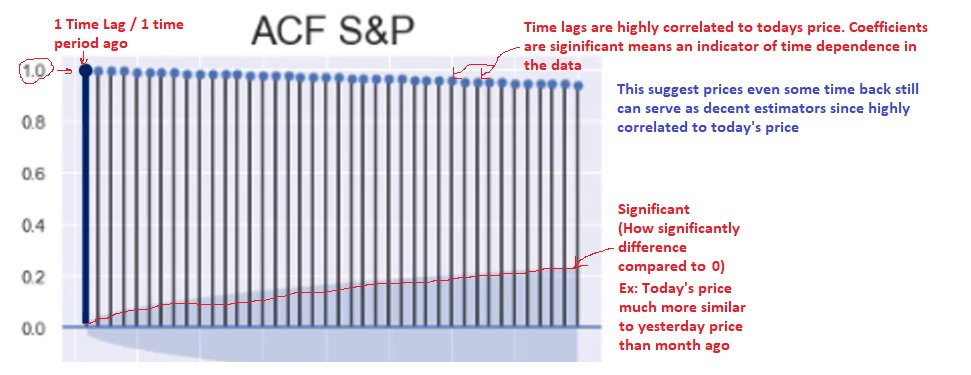

Observations

1. Thin lines indcates autocorrelation between todays price to its laged versions (First line indicates the autocorelation of one time period ago / Seond line indicates two time periods ago and so on)
2. Autocorrelation barely dimishes when the lag increases, this suggests that prices even months back are good estimators for today's price 
3. Blue area represents Significance. This area expands when the lag values are increasing. The greater the distance in time, the more unlikely it is that this autocorrelation persists
(Ex: Today's price much more closer to yesterday's price than month ago) Therefore autocorrelation coefficient of the higher lags are sufficiently greater to be significant than the zero

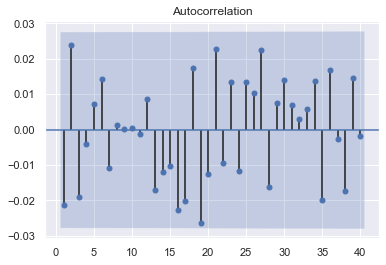

In [11]:
# White noise ACF
sgt.plot_acf(train_spx['wn'], lags=40, zero=False)
plt.show()

Observation

Lagged Prices are significantly difference to today's prices. Arbitary positive and negative correlation. Defnetly no Autocorelation as we expected. No Time dependence in the data

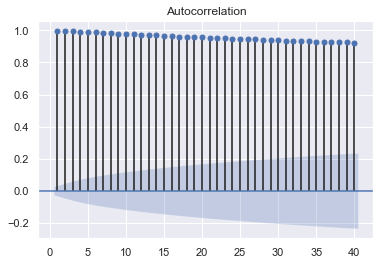

In [12]:
# Random Walk ACF
sgt.plot_acf(train_spx['rw'], lags=40, zero=False)
plt.show()

Observation

Laged prices are highly correlated to today's price that means there's a time dependence in the data. Also autocorelation barely diminishes when the lag increases that means even past months data are also good estimators to forecast futhure data.

### PACF

Partial Autocorrelation Function (PACF)

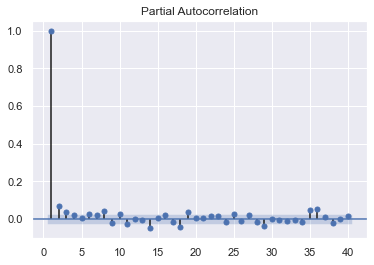

In [13]:
sgt.plot_pacf(train_spx['spx'], lags=40, zero=False, method=('ols')) # ols = Ordinary Least Square
plt.show()

Observation



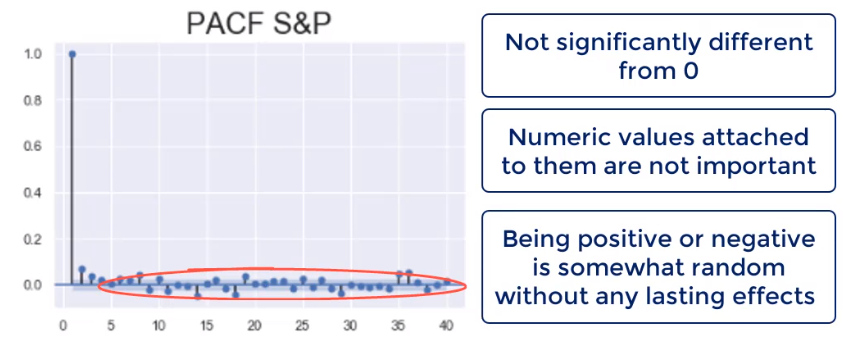

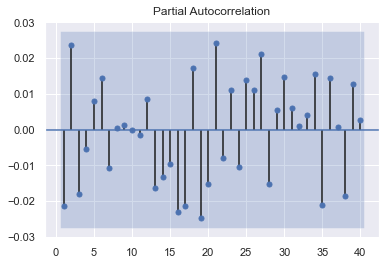

In [14]:
# White Noise PACF
sgt.plot_pacf(train_spx['wn'], lags=40, zero=False, method=('ols')) # ols = Ordinary Least Square
plt.show()

Observation

Lags are highly uncorrelated to today price when the lags increases. Coefficients are not significant. No autocorrelation in White Noise 

In Summary

The difference between ACF and PACF is

The ACF measures the accumulated effects, past lags have on the current value, while the PACF measures the direct effect

## Picking the correct Model

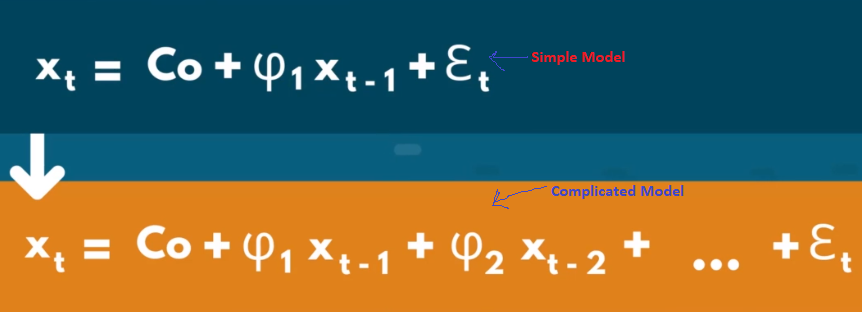

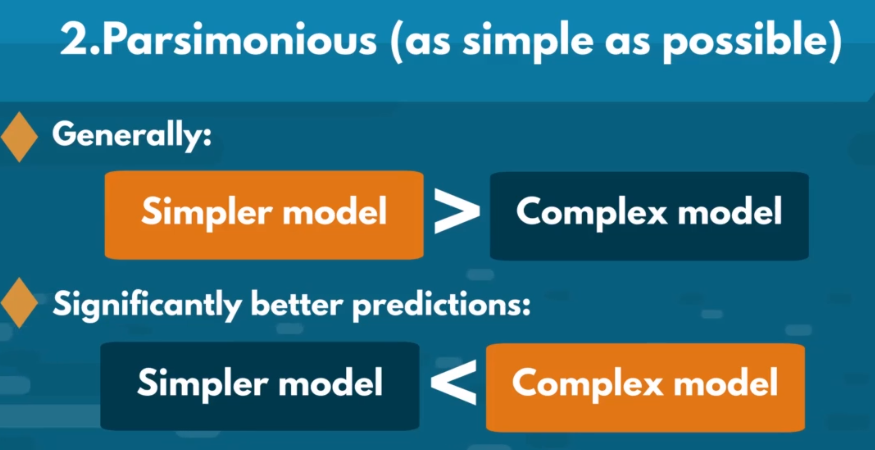

Summary

If we are comparing two models and we want to choose the best fit, then we choose the one with

Higher Log-Likehood and Lower Information Criteria

# Autoregressive Model (AR)

A linear model, where current periods values are a sum of past outcomes multiplied by a numeric factor. So it uses a lagged version of itself (auto) to conduct the regression

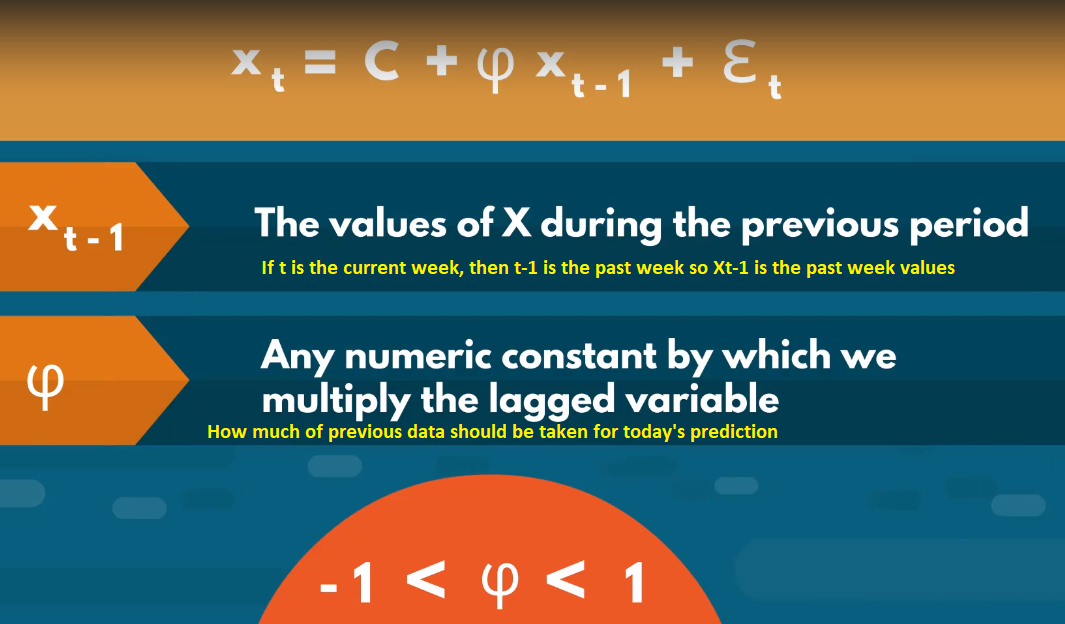

here ρ should be between -1 to 1 because explained by below example

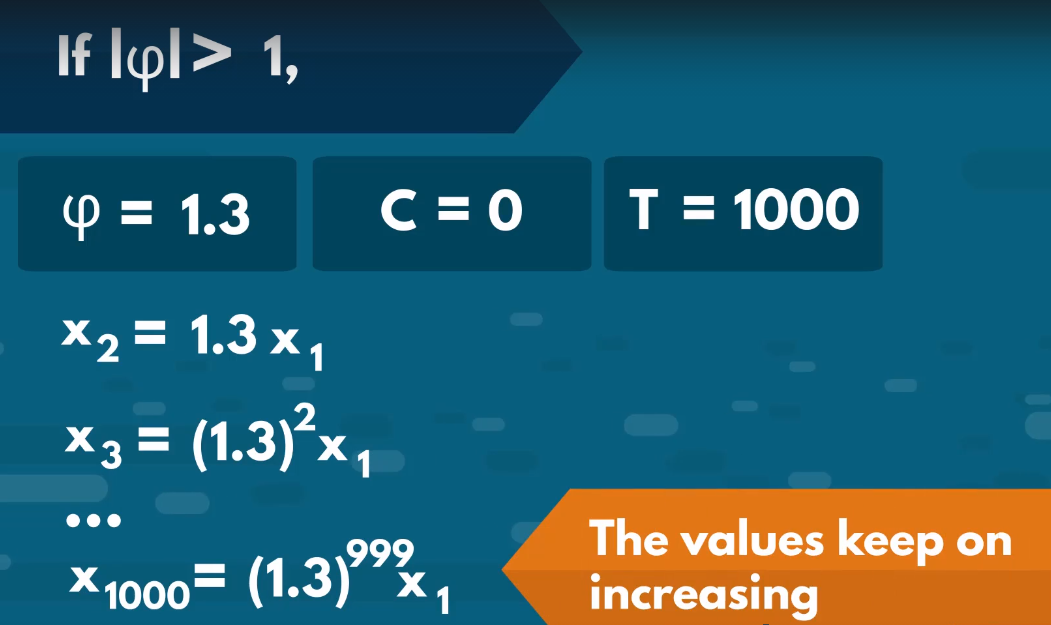

SO, we have to make sure it is between -1 to 1 

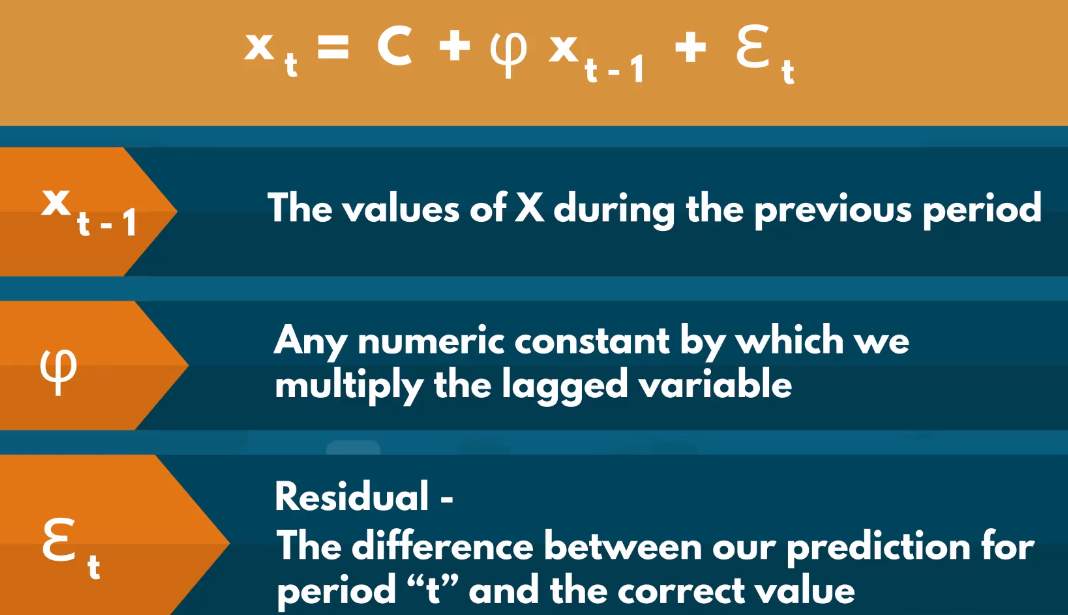

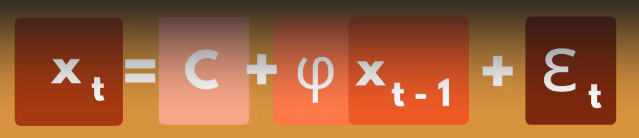

## How many Lags should be chosen?

For example if lags = 2

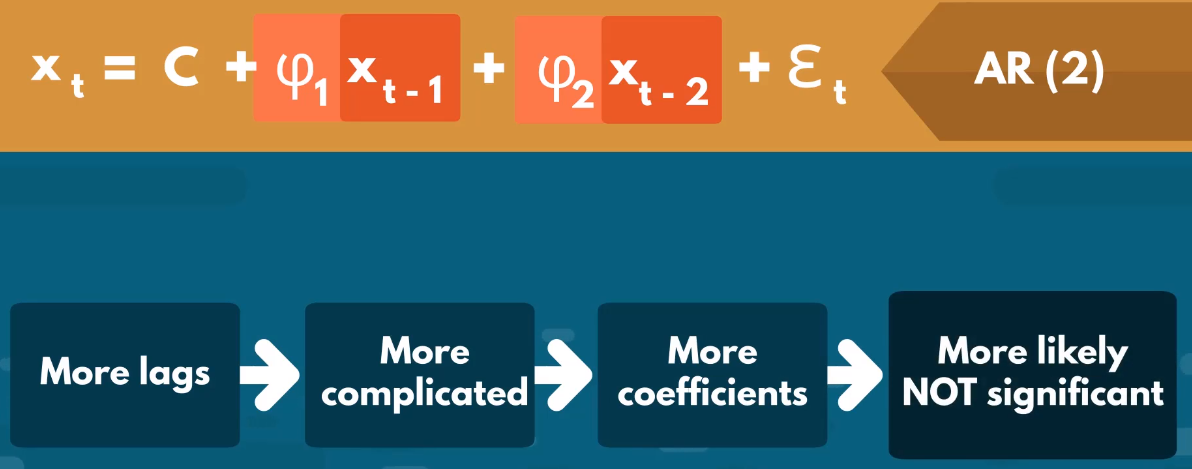

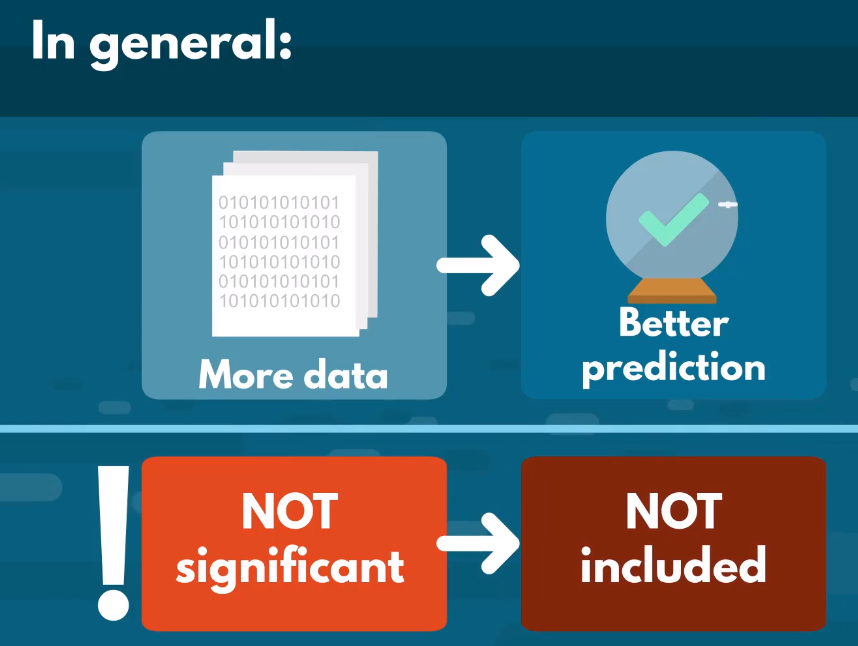

 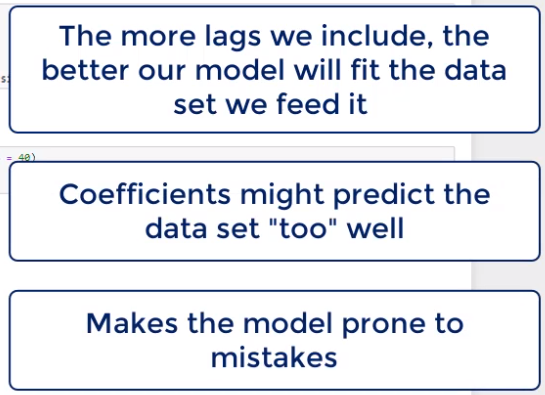

Since we are interested in less parameter model / simpler model compared to complex model, we have to use PACF model, because it indicates Directly Correlated time lags as opposed to ACF which has Indirect time lags info when choosing a lag.

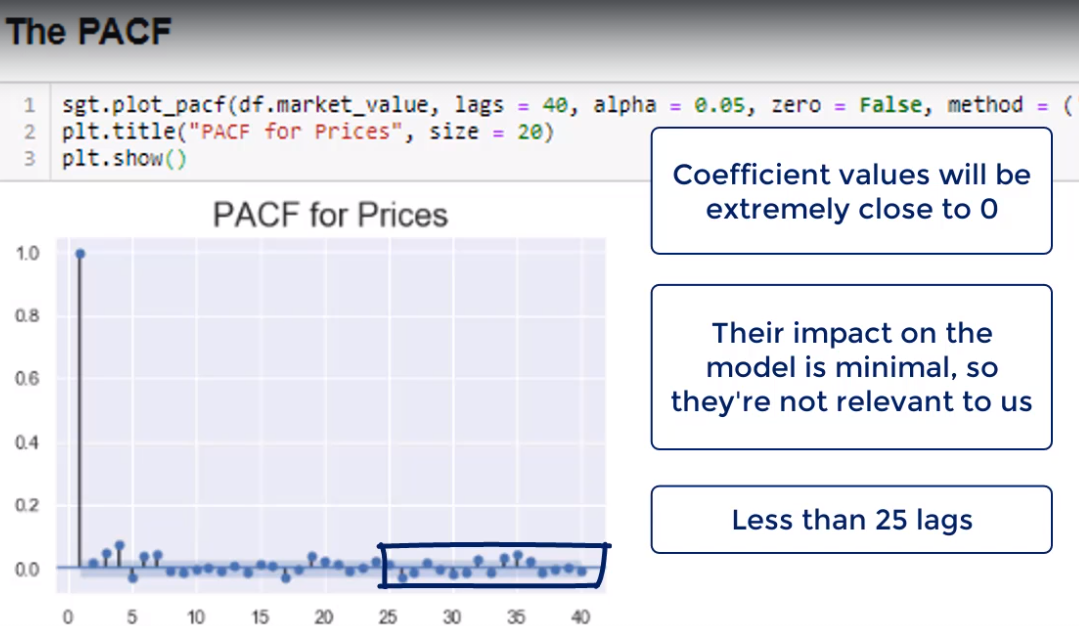

## As we can see First Lag is pretty significant so we must include the First Lag!